# Delaying a connection with a node

Nodes allow for all sorts of advanced behavior
that is typically done by modifying the code of a neural simulator.
In Nengo, the `Node` object allows us to run custom code.

In this example, we will implement
an `n`-timestep delayed connection by using a node.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import nengo
from nengo.processes import WhiteSignal

In [2]:
model = nengo.Network(label="Delayed connection")
with model:
    # We'll use white noise as input
    inp = nengo.Node(WhiteSignal(2, high=5), size_out=1)
    A = nengo.Ensemble(40, dimensions=1)
    nengo.Connection(inp, A)


# We'll make a simple object to implement the delayed connection
class Delay:
    def __init__(self, dimensions, timesteps=50):
        self.history = np.zeros((timesteps, dimensions))

    def step(self, t, x):
        self.history = np.roll(self.history, -1)
        self.history[-1] = x
        return self.history[0]


dt = 0.001
delay = Delay(1, timesteps=int(0.2 / 0.001))

with model:
    delaynode = nengo.Node(delay.step, size_in=1, size_out=1)
    nengo.Connection(A, delaynode)

    # Send the delayed output through an ensemble
    B = nengo.Ensemble(40, dimensions=1)
    nengo.Connection(delaynode, B)

    # Probe the input at the delayed output
    A_probe = nengo.Probe(A, synapse=0.01)
    B_probe = nengo.Probe(B, synapse=0.01)

In [3]:
# Run for 2 seconds
with nengo.Simulator(model) as sim:
    sim.run(2)

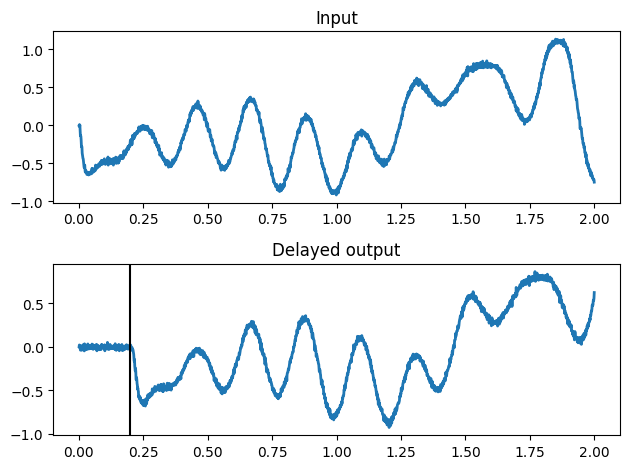

In [4]:
# Plot the results
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(sim.trange(), sim.data[A_probe], lw=2)
plt.title("Input")
plt.subplot(2, 1, 2)
plt.plot(sim.trange(), sim.data[B_probe], lw=2)
plt.axvline(0.2, c="k")
plt.title("Delayed output")
plt.tight_layout()